In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai')
from IPython.display import Image, display
import pickle
import pprint

import qiskit
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit import IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import qiskit.ignis.mitigation as mit

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [2]:
import importlib
import bell_ineq
importlib.reload(bell_ineq)
from bell_ineq import *
import graph_lib
from graph_lib import *
import graph_state_lib
from graph_state_lib import *

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
print(provider) 

<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>


In [4]:
vertex_list = [20,19,16,14,11,8,5,3,2,1,4,7,10,12,15,18,21,23,24,25,26]
max_size = len(vertex_list) # largest graph size
initial_layouts = [vertex_list[:n] for n in range(1, max_size + 1)] # initial_layouts
F_list = [3 * i + 1 for i in range(max_size // 3)] # subset of focused vertices of graph size max_size
Fs = [F_list[:(n+1) // 3] for n in range(1, max_size + 1)] # subsets of focused vertices of graph size 1 to max_size
adj_lists = [adjacency_list_for_path_graph(n) for n in range(1, max_size + 1)] # adjacency list of graph size 1 to max_size
graphs = [list_to_matrix(adj_list) for adj_list in adj_lists] # adjacency matrix of graph size 1 to max_size
shots_per_circuit = 1 << 13 # shots per one execution
shots_scale_per_graph = [1 << 5] * len(adj_lists) # the scale of shots of each graph
graph_sizes = [len(adj_list) for adj_list in adj_lists]

In [5]:
parity_table = make_parity_table(10)
print(len(parity_table))

1024


In [6]:
print("max_size:", max_size)
print("shots_per_circuit:", shots_per_circuit)
print("shots_scale_per_graph:", shots_scale_per_graph)
print("graph_sizes:", graph_sizes)
print("F_list:", F_list)
print([len(i) for i in initial_layouts])
pprint.pprint(initial_layouts)

max_size: 21
shots_per_circuit: 8192
shots_scale_per_graph: [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
graph_sizes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
F_list: [1, 4, 7, 10, 13, 16, 19]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[[20],
 [20, 19],
 [20, 19, 16],
 [20, 19, 16, 14],
 [20, 19, 16, 14, 11],
 [20, 19, 16, 14, 11, 8],
 [20, 19, 16, 14, 11, 8, 5],
 [20, 19, 16, 14, 11, 8, 5, 3],
 [20, 19, 16, 14, 11, 8, 5, 3, 2],
 [20, 19, 16, 14, 11, 8, 5, 3, 2, 1],
 [20, 19, 16, 14, 11, 8, 5, 3, 2, 1, 4],
 [20, 19, 16, 14, 11, 8, 5, 3, 2, 1, 4, 7],
 [20, 19, 16, 14, 11, 8, 5, 3, 2, 1, 4, 7, 10],
 [20, 19, 16, 14, 11, 8, 5, 3, 2, 1, 4, 7, 10, 12],
 [20, 19, 16, 14, 11, 8, 5, 3, 2, 1, 4, 7, 10, 12, 15],
 [20, 19, 16, 14, 11, 8, 5, 3, 2, 1, 4, 7, 10, 12, 15, 18],
 [20, 19, 16, 14, 11, 8, 5, 3, 2, 1, 4, 7, 10, 12, 15, 18, 21],
 [20, 19, 16, 14, 11, 8, 5, 3, 2, 1, 4, 7, 10, 12, 15, 1

In [7]:
qcs = [path_graph_state(size) for size in range(1, max_size+1)]
qcs_list, nums_divide_list = prepare_qcs_list(qcs, 
                                              adj_lists, 
                                              Fs, 
                                              shots_per_circuit, 
                                              shots_scale_per_graph,
                                              measure_last=True,
                                              optimization_level=1)
ops_qcs_list = [qc.count_ops() for qc in qcs_list]
print(len(qcs_list), "quantum circuits")

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


230 quantum circuits


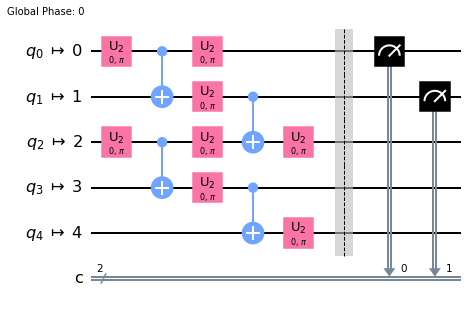

In [8]:
qcs_list[10].draw("mpl")

In [9]:
exec_initial_layout = []
for i, num_circuits in enumerate([len(nums_divide) for nums_divide in nums_divide_list]):
    exec_initial_layout += [initial_layouts[i]] * num_circuits

In [10]:
jobs = execute_circuits(qcs_list,
                        backend='ibm_kawasaki', 
                        provider=provider, 
                        shots=shots_per_circuit,
                        max_experiments=900,
                        optimization_level=1,
                        initial_layout=exec_initial_layout)
print(len(jobs), "jobs")

given provider:  <AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>
running on ibm_kawasaki
circuits from 0 to 230 are put on the real device.
1 jobs


In [11]:
with open("job_ids_kawasaki_path.pkl", "wb") as f:
    pickle.dump([job.job_id() for job in jobs], f)

In [12]:
device = provider.backends.ibm_kawasaki
backend = provider.get_backend('ibm_kawasaki')
with open("kawasaki_properties_path.pkl", "wb") as f:
    pickle.dump(device.properties(), f)

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  """Entry point for launching an IPython kernel.


In [13]:
with open("job_ids_kawasaki_path.pkl", "rb") as f:
    job_ids = pickle.load(f)

In [14]:
counts_dict_list = job_ids_to_counts(job_ids, device)
print(len(counts_dict_list))

230


In [15]:
def analyze_circuits(adj_lists, Fs, counts_list):
    """
    Input
        adj_lists         : list of adjacency list
        Fs                : list of vertex subset
        counts_list       : list of int list (list of counts)
    Output
        corr_all_list : list of float (correlation of each graph)
        stddev_all_list : list of float (standard deviation of each graph)
        Es_all_list   : list of list (term-wise correlation of each graph)
        Ds_all_list   : list of list (term-wise stddev of each graph)
    """
    assert len(adj_lists) == len(Fs)
    corr_all_list, stddev_all_list, Es_all_list, Ds_all_list = [], [], [], []
    begin = 0
    for adj_list, F in zip(adj_lists, Fs):
        print("graph size:", len(adj_list))
        Es_F, Ds_F, corr_F, n = [], [], 0, len(adj_list)
        if n <= 1:
            print("skipped\n")
            corr_all_list.append(0)
            stddev_all_list.append(0)
            Es_all_list.append([])
            Ds_all_list.append([])
            continue
        remaining = remaining_vertices(adj_list, n, F)
        for m in F:
            # corr_itself = E(shots_per_circuit * next(nums_divide), counts_list[begin], parity_table)
            corr_itself, stddev_itself = mit.expectation_value(counts_list[begin])
            corr_deg, begin = corr_itself * len(adj_list[m]), begin + 1
            Es_m, Ds_m = [corr_itself], [stddev_itself * len(adj_list[m])]
            for j, _ in enumerate(adj_list[m]):
                expval, stddev = mit.expectation_value(counts_list[begin:begin + len(adj_list[m])][j])
                Es_m.append(expval)
                Ds_m.append(stddev)
                # + [E(shots_per_circuit * next(nums_divide), counts_list[begin:begin + len(adj_list[m])][j], parity_table) for j, v in enumerate(adj_list[m])]
            sum_corr, begin = corr_deg + sum(Es_m[1:]), begin + len(adj_list[m])
            print("correlation on n[", m, "]:", sum_corr)
            corr_F += sum_corr
            Es_F.append(Es_m)
            Ds_F.append(Ds_m)

        # remainig part
        # Es_R = [E(shots_per_circuit * next(nums_divide), counts_list[begin:begin+len(remaining)][i], parity_table) for i, v in enumerate(remaining)]
        Es_R, Ds_R = [], []
        for i, _ in enumerate(remaining):
            expval, stddev = mit.expectation_value(counts_list[begin:begin+len(remaining)][i])
            Es_R.append(expval)
            Ds_R.append(stddev)
        corr_R = sum(Es_R)
        begin += len(remaining)
        print("correlation on remaining vertices:", corr_R)

        corr_F *= np.sqrt(2)
        corr_all = corr_F + corr_R
        corr_all_list.append(corr_all)
        # print(Ds_F, Ds_R)
        stddev_all_list.append(np.sqrt(2 * sum([dev ** 2 for Ds_m in Ds_F for dev in Ds_m]) + sum([dev ** 2 for dev in Ds_R])) )
        Es_all_list.append([Es_F, Es_R])
        Ds_all_list.append([Ds_F, Ds_R])
        print("total correlation:", corr_all, "\n")
    return corr_all_list, stddev_all_list, Es_all_list, Ds_all_list

In [16]:
corr_list_real, stddev_list_real, Es_list_real, Ds_list_real = analyze_circuits(adj_lists, 
                                                Fs, 
                                                counts_dict_list)

graph size: 1
skipped

graph size: 2
correlation on n[ 1 ]: 1.888427734375
correlation on remaining vertices: 0
total correlation: 2.670640113514622 

graph size: 3
correlation on n[ 1 ]: 3.6748046875
correlation on remaining vertices: 0
total correlation: 5.196958628134723 

graph size: 4
correlation on n[ 1 ]: 3.635009765625
correlation on remaining vertices: 0.95751953125
total correlation: 6.098199641155521 

graph size: 5
correlation on n[ 1 ]: 3.642822265625
correlation on n[ 4 ]: 1.900390625
correlation on remaining vertices: 0
total correlation: 7.839286849043243 

graph size: 6
correlation on n[ 1 ]: 3.631591796875
correlation on n[ 4 ]: 3.44873046875
correlation on remaining vertices: 0
total correlation: 10.013087774019075 

graph size: 7
correlation on n[ 1 ]: 3.634033203125
correlation on n[ 4 ]: 3.527099609375
correlation on remaining vertices: 0.952392578125
total correlation: 11.079763723517488 

graph size: 8
correlation on n[ 1 ]: 3.62939453125
correlation on n[ 4 ]: 

In [17]:
c_bounds = [0] + [n + (n // 3) for n in range(2, max_size + 1)]
q_bounds = [0]
for n in range(2, max_size + 1):
    q_bounds.append( 2 * (np.sqrt(2) * 2 - 1) * (n // 3) + n - ((n + 1) // 3))
    if (n + 1) % 3 == 0:
        q_bounds[-1] += (np.sqrt(2) * 2 - 1)

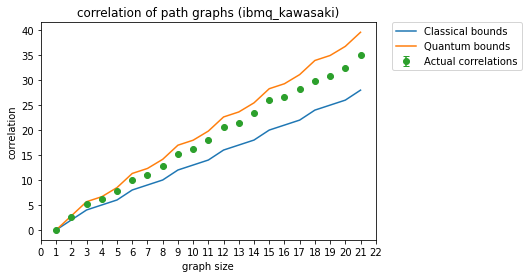

In [18]:
plt.clf()
plt.plot(list(range(1, max_size + 1)), c_bounds, label="Classical bounds") # , marker="o", markersize=1)
plt.plot(list(range(1, max_size + 1)), q_bounds, label="Quantum bounds") # , marker="x", markersize=1)
plt.errorbar(list(range(1, max_size + 1)), corr_list_real, label="Actual correlations", fmt="o", yerr=stddev_list_real, capsize=3)
# plt.errorbar(list(range(1, 11 + 1)), tensored_corr_list_real, label="Mitigated correlations", fmt="*", yerr=tensored_stddev_list_real, capsize=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel("graph size")
plt.ylabel("correlation")
plt.xticks(list(range(max_size + 2)))
plt.title("correlation of path graphs (ibmq_kawasaki)")
plt.show()